In [1]:
import graphlab as gl
import pandas as pd
import numpy as np
from pymongo import MongoClient
import cPickle as pickle
import seaborn as sns
%matplotlib inline
sns.set_style('white')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1470793785.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1470793785.log


This non-commercial license of GraphLab Create for academic use is assigned to jat257@cornell.edu and will expire on June 30, 2017.


In [2]:
df = pd.read_csv('../data/itemData.csv')
df = df.drop(labels=['Unnamed: 0'], axis=1)

In [3]:
df.head().T

,0,1,2,3,4
hike_name,Grand Park via Lake Eleanor,Shellrock Pass,Soda Peaks Lake,Shorthorn,West Fork Teanaway River
hike_id,0,1,2,3,4
numReports,212,2,24,5,5
total_dist,8,NaN,7,5.6,19.2
elevation gain,1100,NaN,2500,1400,2800
time_from_seattle,116.533,NaN,227.333,207.433,115.75
Coast,0,0,0,0,0
stars,4.25,2.33,3,3.67,2.75
Dogs allowed on leash,0,1,0,1,1
Established campsites,1,0,0,0,1


## Using Feature Importance from Gradient Boosting to get weights

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
df = df.dropna()
X = df[[u'elevation gain', u'time_from_seattle', u'numReports', 
        u'total_dist', u'Coast',
       u'Dogs allowed on leash', u'Established campsites', u'Fall foliage',
       u'Good for kids', u'Lakes', u'Mountain views', u'Old growth',
       u'Ridges/passes', u'Rivers', u'Summits', u'Waterfalls',
       u'Wildflowers/Meadows', u'Wildlife']]
y = df.stars
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
gb = GradientBoostingRegressor(min_samples_leaf=3, random_state=0).fit(X_train, y_train)
print 'RMSE: ', np.sqrt(mean_squared_error(y_test, gb.predict(X_test)))

RMSE:  1.0608949547


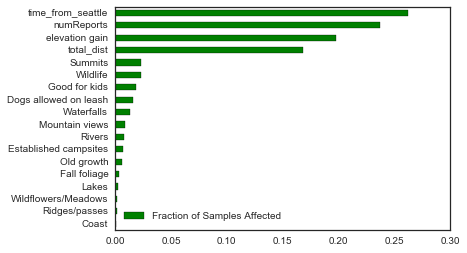

In [6]:
feat_imp = gb.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', color='green')

In [28]:
weights = dict(zip(X.columns, gb.feature_importances_))

In [30]:
sf = gl.SFrame(df.drop(labels=['hike_name'], axis=1))
model = gl.recommender.item_content_recommender.create(sf, item_id='hike_id', weights=weights)

('Applying transform:\n', Class             : AutoVectorizer

Model Fields
------------
Features          : ['numReports', 'total_dist', 'elevation gain', 'time_from_seattle', 'Coast', 'stars', 'Dogs allowed on leash', 'Established campsites', 'Fall foliage', 'Good for kids', 'Lakes', 'Mountain views', 'Old growth', 'Ridges/passes', 'Rivers', 'Summits', 'Waterfalls', 'Wildflowers/Meadows', 'Wildlife']
Excluded Features : ['hike_id']

Column                 Type   Interpretation  Transforms   Output Type
---------------------  -----  --------------  -----------  -----------
numReports             float  numerical       None         float      
total_dist             float  numerical       None         float      
elevation gain         float  numerical       None         float      
time_from_seattle      float  numerical       None         float      
Coast                  int    categorical     astype(str)  str        
stars                  float  numerical       None         float 

Recsys training: model = item_content_recommender


Defaulting to brute force instead of ball tree because there are multiple distance components.

Starting brute force nearest neighbors model training.

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1            | 1413    | 0.0707714   | 16.75ms      |

| Done         |         | 100         | 888.368ms    |

+--------------+---------+-------------+--------------+

Preparing data set.

Data has 0 observations with 0 users and 1413 items.

Data prepared in: 0.304595s

Loading user-provided nearest items.

Generating candidate set for working with new users.

Finished training in 0.050371s

In [44]:
df[df['hike_name']=='Perry Creek']

,hike_name,hike_id,numReports,total_dist,elevation gain,time_from_seattle,Coast,stars,Dogs allowed on leash,Established campsites,...,Good for kids,Lakes,Mountain views,Old growth,Ridges/passes,Rivers,Summits,Waterfalls,Wildflowers/Meadows,Wildlife
165,Perry Creek,165,251.0,10.5,3400.0,96.316667,0,4.0,0,1,...,0,0,1,1,0,0,1,1,1,0


In [45]:
recs = model.recommend_from_interactions([165])

In [47]:
def prettyPrint(scores):
    for score in scores:
        print 'Hike Name: ', df.ix[score]['hike_name']
        print 'Miles: ', df.ix[score]['total_dist']
        print 'EG: ', df.ix[score]['elevation gain']

In [48]:
prettyPrint(recs['hike_id'])

Hike Name:  Surprise and Glacier Lakes
Miles:  11.0
EG:  2700.0
Hike Name:  Summerland - Panhandle Gap
Miles:  12.0
EG:  2950.0
Hike Name:  Hidden Lake Lookout
Miles:  8.0
EG:  3300.0
Hike Name:  McClellan Butte
Miles:  9.0
EG:  3700.0
Hike Name:  Cutthroat Lakes via Walt Bailey Trail
Miles:  10.0
EG:  2300.0
Hike Name:  Mount Defiance
Miles:  11.0
EG:  3584.0
Hike Name:  Mailbox Peak
Miles:  9.4
EG:  4000.0
Hike Name:  Navaho Pass
Miles:  11.0
EG:  3000.0
Hike Name:  Hannegan Pass and Peak
Miles:  10.4
EG:  3100.0
Hike Name:  Rampart Ridge - Rampart Lakes
Miles:  11.0
EG:  2200.0


In [50]:
#Pickling weights

In [51]:
with open('../pickle/weights.pkl', 'wb') as f:
    pickle.dump(weights, f)